In [1]:
import os 
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import requests
import cv2 
from numpy.polynomial import Polynomial
from skimage.morphology import skeletonize, binary_closing, square, binary_erosion, binary_dilation, medial_axis, thin, disk, convex_hull_image, diamond, star, isotropic_closing, remove_small_objects
from skimage.filters import threshold_otsu
import json

In [6]:
sem_segm_img_path = "/Users/senneloobuyck/Documents/Thesis_project/04_matching/2023_RVV_1_6375.0.jpg"
# mapbox_imgs_dir_path = "/Users/senneloobuyck/Documents/Thesis_project/04_matching/mapbox_images_for_frame_1275_RVV1"
heli_lat = 50.77718166666666
heli_lon = 3.52441
intersec_lat = 50.7786715
intersec_lon = 3.5252944
altitude = 158.12

In [7]:
def plot_image(img):
    plt.figure(figsize=(20,10))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

In [8]:
def calculate_bearing(lat1, long1, lat2, long2) : 
    lat1 = math.radians(lat1)
    long1 = math.radians(long1)
    lat2 = math.radians(lat2)
    long2 = math.radians(long2)

    d_long = long2 - long1

    y = math.sin(d_long) * math.cos(lat2)
    x = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(d_long)

    brng = math.atan2(y, x)

    brng = math.degrees(brng)
    brng = (brng + 360) % 360
    # brng = 360 - brng # count degrees clockwise - remove to make counter-clockwise
    return brng

In [9]:
def haversine(lat1, lon1, lat2, lon2) : 
    R = 6371
    d_lat = math.radians(lat2 - lat1)
    d_lon = math.radians(lon2 - lon1)
    lat1 = math.radians(lat1)
    lat2 = math.radians(lat2)
    a = math.sin(d_lat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(d_lon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = R * c * 1000
    return d

In [10]:
# calculate pitch/tilt
def calculate_pitch(heli_lat, heli_lon, intersec_lat, intersec_lon, heli_df) : 
    dist = haversine(heli_lat, heli_lon, intersec_lat, intersec_lon)

    result = heli_df[(heli_df['lat'] == heli_lat) & (heli_df['lng'] == heli_lon)]
    if not result.empty:
        altitude = result.iloc[0]['alt']

    print(f"Distance: {dist}")
    print(f"Altitude: {altitude}")

    alpha_radian = math.atan2(altitude, dist)
    alpha_degrees = alpha_radian * (180.0 / math.pi)
    pitch = 90 - alpha_degrees
    return pitch 

In [8]:
def get_mapbox_intersection_image(lat, lon, bearing, tilt) : 
    if tilt > 60 :
        tilt = 60
    zoom = 18
    width = 512
    height = 512
    access_token = "pk.eyJ1Ijoic2VubmVsb29idXljayIsImEiOiJjbG1zeDVreHowZmw5Mm1xY2lxeTFtYTB2In0.ymj-xZAfeeivbksi1PJttw" 
    styles_url = "mapbox://styles/senneloobuyck/cllcojw8d00wy01pb6rqcdmm5"

    style_code = styles_url.split('/')[-1]

    url = f"https://api.mapbox.com/styles/v1/senneloobuyck/{style_code}/static/{str(lon)},{str(lat)},{str(zoom)},{str(bearing)},{str(tilt)}/{str(width)}x{str(height)}?access_token={access_token}"

    response = requests.get(url)

    if response.status_code == 200:
        with open(f"{lat},{lon}.png", "wb") as f:
            f.write(response.content)
        print(f"Image saved as {lat},{lon}.png")
    else:
        print("Failed to retrieve image for intersection lat = " + str(lat) + ", lon = " + str(lon))
        print(response.text[:100])

In [11]:
def get_intersection_coordinates(lat, lon) : 
    # some lists and dataframes to store the data
    nodes = []
    intersection_nodes = []
    df_nodes = pd.DataFrame(columns=['id', 'lat', 'lon'])
    df_intersections = pd.DataFrame(columns=['lat', 'lon'])

    overpass_url = "http://overpass-api.de/api/interpreter"


    # first get the ways around the point 
    # .w is a temporary variable that stores the result of the first query
    # node(way_cnt:2-);   // select those nodes that are members of two or more of the given ways
    overpass_query = f"""[out:json];
                        way(around: 300, {lat},{lon})["highway"]->.w;
                        node(way_cnt.w:2-);  
                        out;"""

    response = requests.get(overpass_url, params={'data': overpass_query})

    for item in response.json()['elements']:
        df_intersections.loc[len(df_intersections)] = {'lat': item['lat'], 'lon': item['lon']}


    # print(df_intersections)
    return df_intersections

In [12]:
df_intersections = get_intersection_coordinates(heli_lat, heli_lon)

# read in csv file with heli coordinates
heli_path = "/Users/senneloobuyck/Documents/Thesis_project/01_inputs/csv-files/2023 Ronde van Vlaanderen 1 heli.csv"
heli_df = pd.read_csv(heli_path)
heli_df['lat'] = heli_df.apply(lambda row: float(row['lat']) * 1 if row['NS'] == 'N' else float(row['lat']) * (-1), axis=1)
heli_df['lng'] = heli_df.apply(lambda row: float(row['lng']) * 1 if row['EW'] == 'E' else float(row['lng']) * (-1), axis=1)
heli_df = heli_df[['lat', 'lng', 'alt', 'seconds_from_start']]

for index, row in df_intersections.iterrows() : 
    print(f"Intersection: {row['lat']},{row['lon']}")
    bearing = calculate_bearing(heli_lat, heli_lon, row['lat'], row['lon'])
    print(f"Bearing = {bearing}")
    pitch = calculate_pitch(heli_lat, heli_lon, row['lat'], row['lon'], heli_df)
    print(f"Pitch = {pitch}")
    get_mapbox_intersection_image(row['lat'], row['lon'], bearing, pitch)

Intersection: 50.777904,3.5203477
Bearing = 285.70771136286885
Distance: 296.70757947325524
Altitude: 158.12
Pitch = 61.946165010518186


NameError: name 'get_mapbox_intersection_image' is not defined

In [13]:
def get_skeleton(mask_bgr, contour) : 
    print("Getting the skeleton and the pruned skeleton")

    mask_gray = cv2.cvtColor(mask_bgr, cv2.COLOR_BGR2GRAY)

    # draw contour in white on black background
    contour_mask_gray = np.zeros_like(mask_gray)
    cv2.drawContours(contour_mask_gray, [contour], -1, 255, -1)
    contour_mask_bgr = cv2.cvtColor(contour_mask_gray, cv2.COLOR_GRAY2BGR)
    
    # To avoid the precision loss when converting the image to bool, 
    # you can also binarize the image using one of the available thresholding algorithms
    thresh = threshold_otsu(contour_mask_gray)
    contour_mask_gray = contour_mask_gray > thresh
    
    # 1. Skeletonize
    # skeleton_gray = (skeletonize(contour_mask_gray)).astype(np.uint8)
    skeleton_gray = skeletonize(contour_mask_gray, method='lee').astype(np.uint8)

    np.set_printoptions(threshold=np.inf)
    print("Skeleton image values:")
    print(skeleton_gray)


    plt.figure(figsize=(20,10))
    plt.imshow(skeleton_gray, cmap='gray', interpolation='nearest')
    plt.show()

    skeleton_bgr = cv2.cvtColor(skeleton_gray, cv2.COLOR_GRAY2BGR)

    return skeleton_bgr
            

In [14]:
def get_skeleton_intersection(skeleton):
    """ Given a skeletonised image, it will give the coordinates of the intersections of the skeleton"""
    print("Getting intersections in skeleton (more than 2 neighbours)")
    # A list of valid intersections             
    # These are in the format (clockwise order)
    # 2 3 4
    # 1 C 5
    # 8 7 6 
    validIntersection = [[0,1,0,1,0,0,1,0],[0,0,1,0,1,0,0,1],[1,0,0,1,0,1,0,0],
                         [0,1,0,0,1,0,1,0],[0,0,1,0,0,1,0,1],[1,0,0,1,0,0,1,0],
                         [0,1,0,0,1,0,0,1],[1,0,1,0,0,1,0,0],[0,1,0,0,0,1,0,1],
                         [0,1,0,1,0,0,0,1],[0,1,0,1,0,1,0,0],[0,0,0,1,0,1,0,1],
                         [1,0,1,0,0,0,1,0],[1,0,1,0,1,0,0,0],[0,0,1,0,1,0,1,0],
                         [1,0,0,0,1,0,1,0],[1,0,0,1,1,1,0,0],[0,0,1,0,0,1,1,1],
                         [1,1,0,0,1,0,0,1],[0,1,1,1,0,0,1,0],[1,0,1,1,0,0,1,0],
                         [1,0,1,0,0,1,1,0],[1,0,1,1,0,1,1,0],[0,1,1,0,1,0,1,1],
                         [1,1,0,1,1,0,1,0],[1,1,0,0,1,0,1,0],[0,1,1,0,1,0,1,0],
                         [0,0,1,0,1,0,1,1],[1,0,0,1,1,0,1,0],[1,0,1,0,1,1,0,1],
                         [1,0,1,0,1,1,0,0],[1,0,1,0,1,0,0,1],[0,1,0,0,1,0,1,1],
                         [0,1,1,0,1,0,0,1],[1,1,0,1,0,0,1,0],[0,1,0,1,1,0,1,0],
                         [0,0,1,0,1,1,0,1],[1,0,1,0,0,1,0,1],[1,0,0,1,0,1,1,0],
                         [1,0,1,1,0,1,0,0]]
    skeleton_gray = cv2.cvtColor(skeleton, cv2.COLOR_BGR2GRAY)
    image = skeleton_gray.copy()
    image = image/255
    intersections = []
    for x in range(1,len(image)-1):
        for y in range(1,len(image[x])-1):
            # if we have a white pixel
            if image[x][y] == 1:
                neighbours = [image[x-1][y], image[x-1][y-1], image[x][y-1], image[x+1][y-1], image[x+1][y], image[x+1][y+1], image[x][y+1], image[x-1][y+1]]
                if neighbours in validIntersection:
                    intersections.append((y,x))
    # Filter intersections to make sure we don't count them twice or ones that are very close together
    # for point1 in intersections:
    #     for point2 in intersections:
    #         if (((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2) < 10**2) and (point1 != point2):
    #             intersections.remove(point2)
    # Remove duplicates
    return intersections


In [15]:
def prune_skeleton(skeleton_contour_bgr, skel_intersections, threshold) : 
    print("Pruning the skeleton")
    pruned_skeleton_contour_bgr = np.zeros_like(skeleton_contour_bgr) 
    bad_contours = []
    for intersection in skel_intersections : 
        pruned_skeleton_contour_bgr_help = skeleton_contour_bgr.copy()
        # cv2.circle(pruned_skeleton_contour_bgr_help, (intersection[0], intersection[1]), 1, (0,0,0), -1)
        pruned_skeleton_contour_bgr_help[intersection[1], intersection[0]] = (0,0,0)

        pruned_skeleton_contour_gray_help = cv2.cvtColor(pruned_skeleton_contour_bgr_help, cv2.COLOR_BGR2GRAY)
        contours, hierarchy = cv2.findContours(pruned_skeleton_contour_gray_help, cv2.RETR_EXTERNAL , cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours : 
            if cv2.arcLength(contour, closed=False) > threshold :
                cv2.drawContours(pruned_skeleton_contour_bgr, [contour], contourIdx=-1, color=(255, 255, 255), thickness=1)
            else : 
                bad_contours.append(contour)

    for bad_contour in bad_contours :
        cv2.drawContours(pruned_skeleton_contour_bgr, [bad_contour], contourIdx=-1, color=(0, 0, 0), thickness=1)

    for intersection in skel_intersections : 
        pruned_skeleton_contour_bgr[intersection[1], intersection[0]] = (255,255,255)
    return pruned_skeleton_contour_bgr    

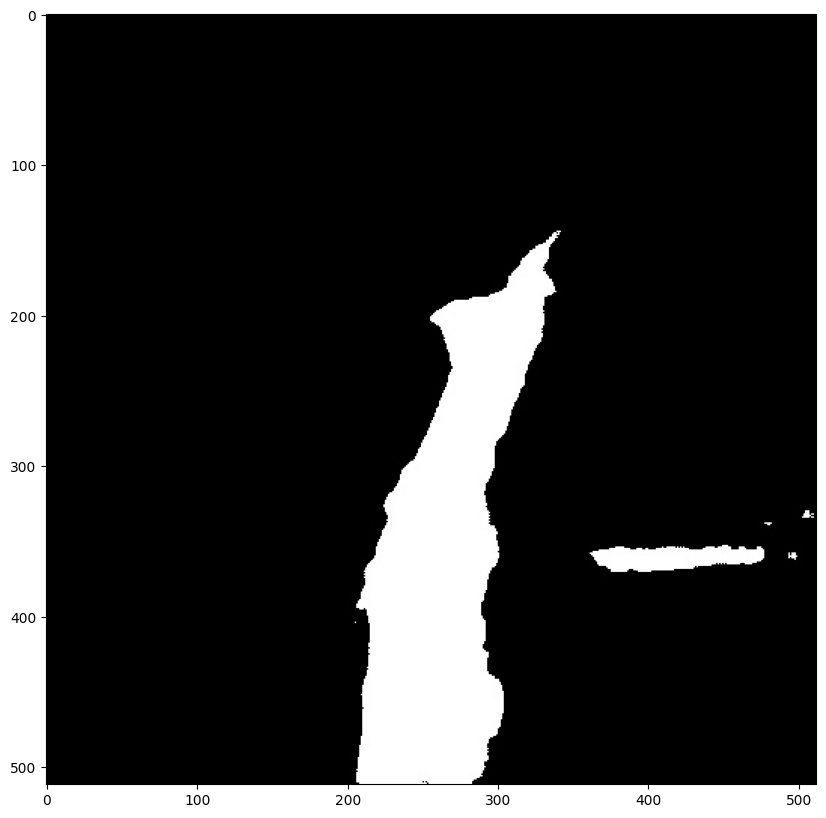

In [16]:
img_bgr = cv2.imread(sem_segm_img_path)
plot_image(img_bgr)

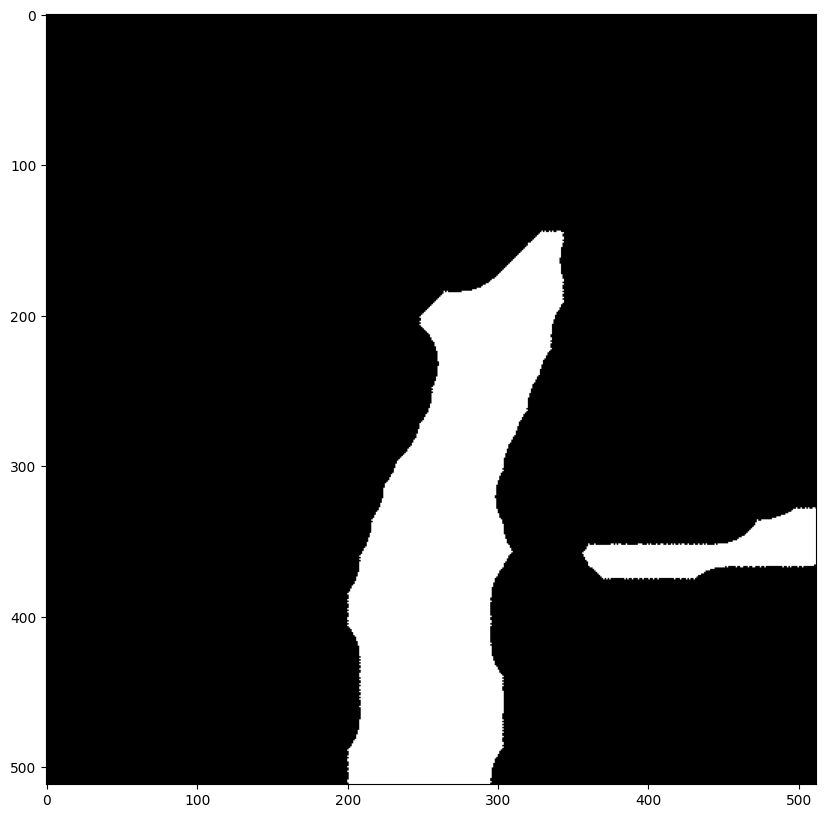

Shape of closing_bgr: (512, 512, 3)


In [17]:
closing_bgr = isotropic_closing(img_bgr, radius=30)
closing_bgr = closing_bgr.astype(np.uint8) * 255
plot_image(closing_bgr)
print(f"Shape of closing_bgr: {closing_bgr.shape}")

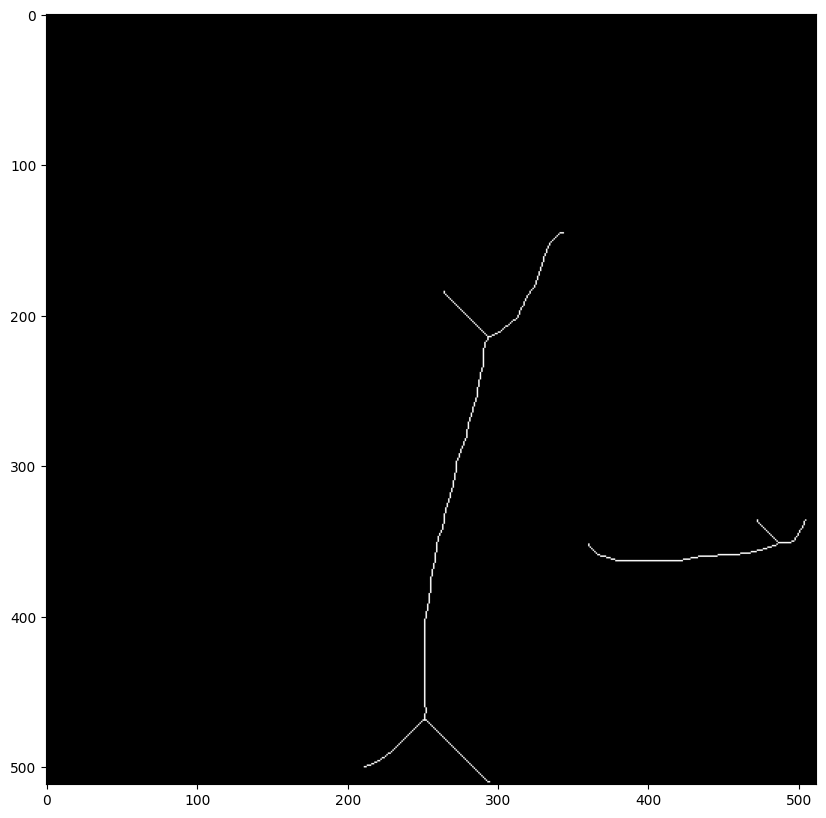

In [18]:
mask_bgr = closing_bgr.copy()
mask_bgr_copy = mask_bgr.copy()
mask_gray = cv2.cvtColor(mask_bgr, cv2.COLOR_BGR2GRAY)
mask_gray_copy = mask_gray.copy()
skeleton_gray = skeletonize(mask_gray)
skeleton_gray = skeleton_gray.astype(np.uint8) * 255
skeleton_bgr = cv2.cvtColor(skeleton_gray, cv2.COLOR_GRAY2BGR)
plot_image(skeleton_bgr)

In [19]:
def get_patch_from_intersection(pruned_skeleton_contour_bgr, prune_intersection, patch_size) : 
    print("Getting patch from intersection")
    pruned_skeleton_contour_gray = cv2.cvtColor(pruned_skeleton_contour_bgr, cv2.COLOR_BGR2GRAY)

    # Calculate the coordinates of the patch boundaries
    x, y = prune_intersection[0], prune_intersection[1]
    x_min, x_max = x - patch_size // 2, x + patch_size // 2 + 1
    y_min, y_max = y - patch_size // 2, y + patch_size // 2 + 1

    # Ensure the coordinates are within the image bounds
    x_min = max(0, x_min)
    x_max = min(pruned_skeleton_contour_gray.shape[1], x_max)
    y_min = max(0, y_min)
    y_max = min(pruned_skeleton_contour_gray.shape[0], y_max)

    # Extract the patch
    patch = pruned_skeleton_contour_gray[y_min:y_max, x_min:x_max]

    # Patch intersection value
    patch_intersection = (patch.shape[0]//2, patch.shape[1]//2)

    # Calculate neighbour pixels that define the roads that intersect (in patch values)
    road_neighbour_pixels = []
    for x in range(-1,2):
        for y in range(-1,2):
            if patch[patch_intersection[1]+y, patch_intersection[0]+x] == 255 and (x != 0 or y != 0):
                road_neighbour_pixels.append((patch_intersection[0]+x, patch_intersection[1]+y))

    return patch, road_neighbour_pixels

In [20]:
def find_road_pixels(patch, reference_pixel, neighbour_pixels, intersection, visited_pixels=None):
    if visited_pixels is None:
        visited_pixels = set()

    print("Finding road pixels")
    print(f"Intersection = {intersection}")
    patch_size = patch.shape[0]
    road_pixels = []

    for x in range(-1, 2):
        for y in range(-1, 2):
            pixel = (reference_pixel[0] + x, reference_pixel[1] + y)

            # Check if the pixel has been visited or is out of bounds
            if pixel[0] < 0 or pixel[0] >= patch_size or pixel[1] < 0 or pixel[1] >= patch_size or pixel in visited_pixels:
                continue

            # Check if the pixel is a road pixel and not the intersection itself
            if patch[pixel[1], pixel[0]] == 255 and (x != 0 or y != 0) and pixel != intersection and pixel not in neighbour_pixels:
                road_pixels.append(pixel)
                visited_pixels.add(pixel)
                # Recursively search from this pixel
                road_pixels += find_road_pixels(patch, pixel, neighbour_pixels, intersection, visited_pixels)
    
    return road_pixels


In [21]:
def get_direction_vectors(patch, neighbour_pixels) : 
    # For visualisation purposes
    patch_bgr = cv2.cvtColor(patch, cv2.COLOR_GRAY2BGR)
    
    # Find intersection and set value to 0
    intersection = (patch.shape[0]//2, patch.shape[1]//2)
    patch[intersection[0], intersection[1]] = 0

    direction_vectors = []
    
    
    
    # if lines is None : 
    #     print("No houghlines found")
    # else :
    #     for i in range(0, len(lines)):
    #         rho = lines[i][0][0]
    #         theta = lines[i][0][1]
    #         a = math.cos(theta)
    #         b = math.sin(theta)
    #         x0 = a * rho
    #         y0 = b * rho
    #         pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    #         pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    #         cv2.line(patch_bgr, pt1, pt2, (0, 0, 255), 3, cv2.LINE_AA)

    # print("Patch with houghlines")
    # plot_image(patch_bgr)

    for neighbour_pixel in neighbour_pixels :
        road_pixels = find_road_pixels(patch, neighbour_pixel, neighbour_pixels, intersection, None)
        road_pixels.append(neighbour_pixel)
        road_pixels.append(intersection)
        print(f"Road pixels for neighbour pixel {neighbour_pixel} (including intersection): ")
        print(road_pixels)

        # now append the neighbour pixel AND the intersection pixel to the road pixels 
        # road_pixels.append(intersection)

        # Switch y values because the y axis is inverted
        road_pixels = [(pixel[0], (patch.shape[0]-1) - pixel[1]) for pixel in road_pixels]

        # Adjust the coordinates of road pixels and intersection to be relative to the center
        adjusted_road_pixels = [(pixel[0] - intersection[0], pixel[1] - intersection[1]) for pixel in road_pixels]

        # convert to numpy array
        road_pixels = np.array(adjusted_road_pixels, dtype=np.float32)
        print(f"Road pixels after adjustment (intersection is now origin): ")
        print(road_pixels)


        # For each set of coordinates, compute the best-fit line
        x_values = np.array([coord[0] for coord in road_pixels])
        y_values = np.array([coord[1] for coord in road_pixels])
        line = np.polyfit(x_values, y_values, deg=1)
        print(f"Line: {line}")

        # Now show the line on the patch
        a = line[0]
        b = line[1]
        y = a * x_values + b
        plt.plot(x_values, y)
        plt.show()

        # The slope of each line gives the direction of the road segment it fits
        direction = np.degrees(np.arctan(a))

        if neighbour_pixel[0] < intersection[0] : 
            direction = direction + 180

        if direction < 0 :
            direction = direction + 360

        print(f"Direction is: {direction}")

        # Calculate the direction vector

        # Fit lines using the points
        # vx, vy, x0, y0 = cv2.fitLine(road_pixels, cv2.DIST_L2, 0, 0.01, 0.01)
        # print(f"vx = {vx}, vy = {vy}, x0 = {x0}, y0 = {y0}")

        # direction_vector = (vx[0], vy[0])

        # # Calculate the angle in radians
        # angle_radians = math.atan2(vy[0], vx[0])

        # # Convert the angle to degrees
        # angle_degrees = math.degrees(angle_radians)

        # print(f"Angle: {angle_degrees} degrees")

        # direction_vectors.append(direction_vector)
    
    
    return direction_vectors


Number of contours: 2
Contour length: 419.44573879241943
Contour area: 3587.0
Convex hull area: 5057.5
Getting the skeleton and the pruned skeleton
Skeleton image values:
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0  

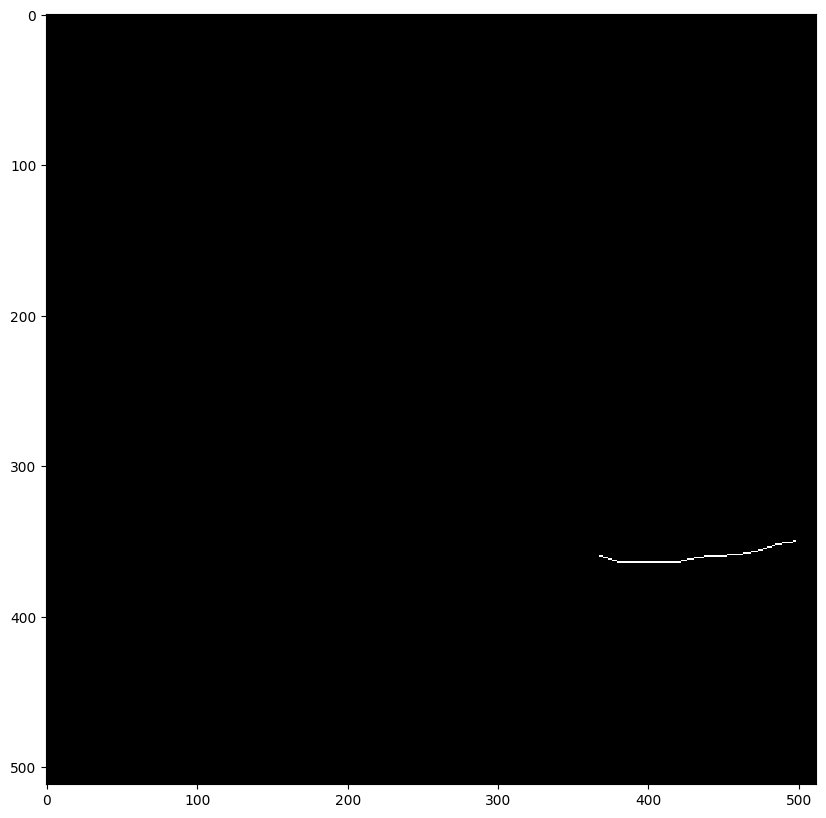

Getting intersections in skeleton (more than 2 neighbours)
0 intersections found in the skeleton
Solidity = 0.7092436974789916 -> no intersection in this contour
Contour length: 1023.4011451005936
Contour area: 28601.0
Convex hull area: 36271.0
Getting the skeleton and the pruned skeleton
Skeleton image values:
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0

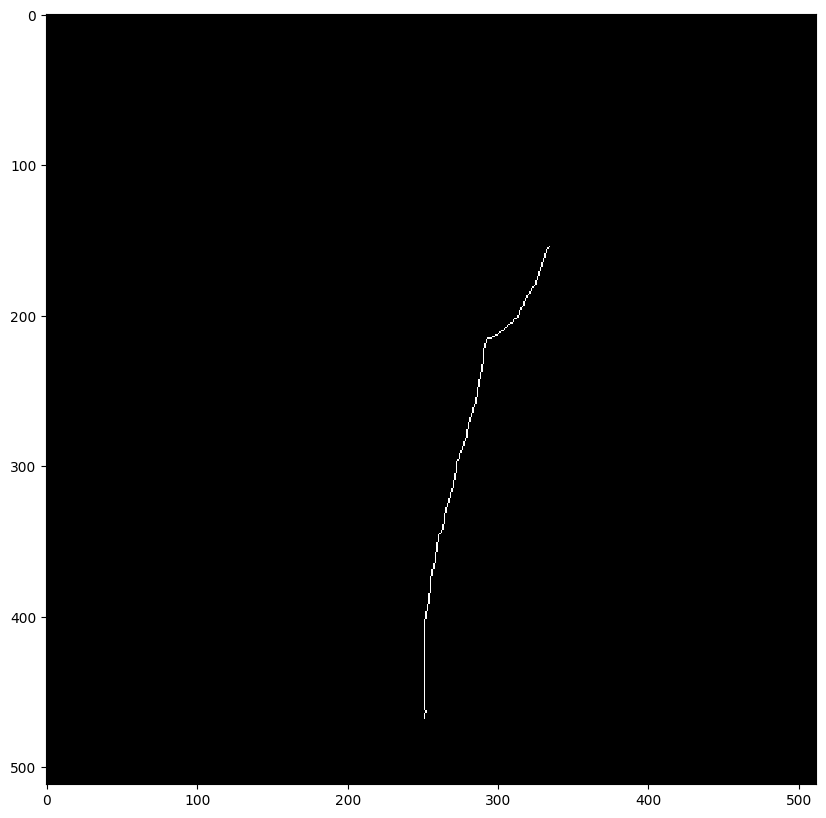

Getting intersections in skeleton (more than 2 neighbours)
0 intersections found in the skeleton
Solidity = 0.7885362962146067 -> no intersection in this contour


In [22]:
contours, hierarchy = cv2.findContours(mask_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(f"Number of contours: {len(contours)}")
cv2.drawContours(mask_bgr_copy, contours, contourIdx=-1, color=(255, 0, 0), thickness=2)

for contour in contours :
    contour_length = cv2.arcLength(contour, closed=True)
    print(f"Contour length: {contour_length}")
    contour_area = cv2.contourArea(contour)
    print(f"Contour area: {contour_area}")

    # measure the irregularity of the polygon
    if contour_length != 0 :
        convex_hull = cv2.convexHull(contour)
        convex_hull_area = cv2.contourArea(convex_hull)
        print(f"Convex hull area: {convex_hull_area}")
        cv2.polylines(mask_bgr_copy, [convex_hull], isClosed=True, color=(0, 255, 0), thickness=3)
        solidity = contour_area / convex_hull_area

        # get skeleton of the contour
        skeleton_contour_bgr = get_skeleton(mask_bgr_copy, contour)
        
        # find the intersections in the skeleton
        skel_intersections = get_skeleton_intersection(skeleton_contour_bgr)

        print(f"{len(skel_intersections)} intersections found in the skeleton")
        
        #  make a decision based on the solidity
        if solidity < 0.60 and skel_intersections != [] :
            print(f"Solidity = {solidity} -> this contour can be related to an intersection in the road")
            
            # prune the skeleton to remove small branches
            threshold = 300
            pruned_skeleton_contour_bgr = prune_skeleton(skeleton_contour_bgr, skel_intersections, threshold)
            plot_image(pruned_skeleton_contour_bgr)
            
            # now find the possible intersection, if there is one
            pruned_skel_intersections = get_skeleton_intersection(pruned_skeleton_contour_bgr)

            # further processing
            if pruned_skel_intersections == [] : 
                print("No intersection is found in a possible intersection contour")
            else : 
                # visualization
                pruned_skeleton_contour_bgr_copy = pruned_skeleton_contour_bgr.copy()
                for intersection in pruned_skel_intersections :
                    pruned_skeleton_contour_bgr_copy[intersection[1], intersection[0]] = [0, 0, 255]
                plot_image(pruned_skeleton_contour_bgr_copy)
                # now try and match intersection with the openstreetmap images
                print("Intersection is found in a possible intersection contour, now try and match it with the openstreetmap images")
                for prune_intersection in pruned_skel_intersections :
                    patch_size = 9
                    patch, neighbour_road_pixels = get_patch_from_intersection(pruned_skeleton_contour_bgr, prune_intersection, patch_size)
                    print(f"Road neighbour pixels: {neighbour_road_pixels}")
                    print(f"Number of roads that intersect in this intersection: {len(neighbour_road_pixels)}")
                    print("Patch:")
                    plt.imshow(patch, cmap='gray')
                    plt.show()
                    print(patch)
                    dir_vectors = get_direction_vectors(patch, neighbour_road_pixels)
        else :
            print(f"Solidity = {solidity} -> no intersection in this contour")